In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as sch
import seaborn as sns
import tensorflow as tf

import glob
import pickle
import time

from matplotlib import colors

from numpy import unique, where

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler

from yellowbrick.cluster import KElbowVisualizer
from mlxtend.frequent_patterns import fpgrowth
from sklearn.decomposition import TruncatedSVD
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix, hstack, vstack
from sklearn.neighbors import NearestNeighbors

In [2]:
sns.set_style("darkgrid")

In [3]:
interactions = pd.read_csv("D:\\Northeastern\\Spring 2024\\DS5230\\Final Project\\Data\\RAW_interactions.csv")
recipes = pd.read_csv("D:\\Northeastern\\Spring 2024\\DS5230\\Final Project\\Data\\RAW_recipes.csv")

In [4]:
interactions = interactions.dropna()
interactions.shape

(1132198, 5)

In [5]:
interactions.head(3)

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...


In [6]:
recipes = recipes.dropna()
recipes.shape

(226657, 12)

In [7]:
recipes.head(3)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13


In [8]:
recipes = recipes.dropna()
recipes.shape

(226657, 12)

In [9]:
raw_int = interactions.copy()
raw_rec = recipes.copy()

# Data Processing

In [10]:
# filter users that rated more than 200 recipes 
interactions = interactions.groupby('user_id').filter(lambda x: len(x) > 200)
interactions = interactions[interactions['rating'] == 5]

In [11]:
# Filter the recipes df to keep only those recipes present in interactions df
# unique_recipe_ids = interactions['recipe_id'].unique()
# recipes = recipes[recipes['id'].isin(unique_recipe_ids)]

In [12]:
merged_df = pd.merge(interactions, recipes, left_on='recipe_id', right_on='id')

In [13]:
rec_nutr = raw_rec[['id', 'nutrition']]
#rec_nutr = rec_nutr.set_index('id')

rec_nutr = rec_nutr['nutrition'].str.split(',', expand=True)
rec_nutr.columns = ["calories", "total_fat", "sugar", "sodium", "protein", "sat_fat", "carbs"]
rec_nutr = rec_nutr.replace('[\[\]]', '', regex=True)
rec_nutr = rec_nutr.apply(pd.to_numeric, errors='coerce')

rec_nutr.head()

<>:6: DeprecationWarning: invalid escape sequence '\['
<>:6: DeprecationWarning: invalid escape sequence '\['
C:\Users\Victoria\AppData\Local\Temp\ipykernel_10852\1936161040.py:6: DeprecationWarning: invalid escape sequence '\['
  rec_nutr = rec_nutr.replace('[\[\]]', '', regex=True)


,calories,total_fat,sugar,sodium,protein,sat_fat,carbs
0,51.5,0.0,13.0,0.0,2.0,0.0,4.0
1,173.4,18.0,0.0,17.0,22.0,35.0,1.0
2,269.8,22.0,32.0,48.0,39.0,27.0,5.0
3,368.1,17.0,10.0,2.0,14.0,8.0,20.0
4,352.9,1.0,337.0,23.0,3.0,0.0,28.0


In [14]:
interacts = raw_int[['user_id', 'recipe_id', 'date', 'rating']]

In [15]:
# Get the ratings for each recipe
mean_ratings = interacts.groupby('recipe_id')['rating'].mean()
mean_ratings = mean_ratings.reset_index()
mean_ratings.columns = ['recipe_id', 'mean_rating']

In [16]:
food = raw_rec.set_index('id')

food = food.join(rec_nutr)
food = food.drop(columns=['nutrition', 'description', 'ingredients', 'name', 'steps'])
food = food.rename_axis('recipe_id')

review = food.join(interacts.groupby('recipe_id').size().rename('reviews'))
food['reviews'] = review['reviews'].fillna(0)
food = food.join(mean_ratings.set_index('recipe_id'))
food['submitted'] = pd.to_datetime(food['submitted'])
food = food.reset_index()

food.head(3)

,recipe_id,minutes,contributor_id,submitted,tags,n_steps,n_ingredients,calories,total_fat,sugar,sodium,protein,sat_fat,carbs,reviews,mean_rating
0,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...",11,7,43.4,0.0,0.0,1.0,0.0,0.0,0.0,3.0,5.0
1,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...",9,6,389.2,13.0,28.0,39.0,55.0,13.0,17.0,4.0,3.5
2,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...",6,13,299.9,36.0,27.0,9.0,20.0,21.0,5.0,1.0,4.0


In [17]:
tags = food['tags'].str.split(', ', expand=True)

variables = tags.stack().unique()

# Print the variables
# print(variables)

In [18]:
# clean variables removing ' and []
variables = [var.replace("'", "") for var in variables]
variables = [var.replace("[", "") for var in variables]
variables = [var.replace("]", "") for var in variables]

tagList = variables

# print(variables)

In [19]:
# print runtime of cell
start_time = time.time()

food['tags'] = food['tags'].astype(str)
food['tags'] = food['tags'].str.replace("[", "").str.replace("]", "").str.replace("'", "").str.replace(", ", " ")

# Initialize a CountVectorizer
vectorizer = CountVectorizer(token_pattern=r'[^\s]+')
tags = vectorizer.fit_transform(food['tags'])

# print runtime of cell
print("--- %s seconds ---" % (time.time() - start_time))

C:\Users\Victoria\AppData\Local\Temp\ipykernel_10852\691653846.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  food['tags'] = food['tags'].str.replace("[", "").str.replace("]", "").str.replace("'", "").str.replace(", ", " ")


--- 4.04546046257019 seconds ---


In [20]:
# convert sparse matrix tags into dataframe
tags = pd.DataFrame(tags.toarray(), columns=vectorizer.get_feature_names_out())

tags.head()

,1-day-or-more,15-minutes-or-less,3-steps-or-less,30-minutes-or-less,4-hours-or-less,5-ingredients-or-less,60-minutes-or-less,a1-sauce,african,american,...,whole-chicken,whole-duck,whole-turkey,wild-game,wings,winter,with,yams-sweet-potatoes,yeast,zucchini
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# concat food dataframe and tags dataframe
food_encoded = pd.concat([food, tags], axis=1)
food_encoded = food_encoded.drop(columns=['tags'])

food_encoded.head()

,recipe_id,minutes,contributor_id,submitted,n_steps,n_ingredients,calories,total_fat,sugar,sodium,...,whole-chicken,whole-duck,whole-turkey,wild-game,wings,winter,with,yams-sweet-potatoes,yeast,zucchini
0,137739,55,47892,2005-09-16,11,7,43.4,0.0,0.0,1.0,...,0,0,0,0,0,1,0,0,0,0
1,31490,30,26278,2002-06-17,9,6,389.2,13.0,28.0,39.0,...,0,0,0,0,0,0,0,0,0,0
2,112140,130,196586,2005-02-25,6,13,299.9,36.0,27.0,9.0,...,0,0,0,0,0,0,0,0,0,0
3,59389,45,68585,2003-04-14,11,11,303.4,3.0,92.0,2.0,...,0,0,0,0,0,0,0,0,0,0
4,44061,190,41706,2002-10-25,5,8,1019.2,43.0,21.0,106.0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
print("Shape of Dataframe: ", food_encoded.shape)

Shape of Dataframe:  (226657, 575)


In [23]:
food_encoded.isnull().sum().sort_values(ascending=False)

carbs        106066
calories     106066
total_fat    106066
sugar        106066
sodium       106066
              ...  
european          0
ethiopian         0
equipment         0
english           0
zucchini          0
Length: 575, dtype: int64

In [24]:
# fill missing values with median
food_encoded = food.fillna(food.median())

C:\Users\Victoria\AppData\Local\Temp\ipykernel_10852\2243161890.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  food_encoded = food.fillna(food.median())
C:\Users\Victoria\AppData\Local\Temp\ipykernel_10852\2243161890.py:2: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  food_encoded = food.fillna(food.median())


In [25]:
food_encoded.isna().any()

recipe_id         False
minutes           False
contributor_id    False
submitted         False
tags              False
n_steps           False
n_ingredients     False
calories          False
total_fat         False
sugar             False
sodium            False
protein           False
sat_fat           False
carbs             False
reviews           False
mean_rating       False
dtype: bool

In [26]:
food_encoded.nunique()

recipe_id         226657
minutes              877
contributor_id     27693
submitted           5081
tags              204471
n_steps               94
n_ingredients         41
calories           16676
total_fat            766
sugar               1937
sodium               703
protein              518
sat_fat              982
carbs                438
reviews              362
mean_rating         2339
dtype: int64

In [27]:
ratings_summary = raw_int.groupby('recipe_id').agg(
    n_ratings=('rating', 'count'), 
    avg_rating=('rating', 'mean')
).reset_index()

In [28]:
ratings_summary['avg_rating'] = ratings_summary['avg_rating'].round(1)

In [29]:
# merge recipes df into ratings_summary df
new_recipes = recipes.merge(ratings_summary, how='left', left_on='id', right_on='recipe_id')
new_recipes = new_recipes.dropna()
new_recipes['n_ratings'] = new_recipes['n_ratings'].astype(int)
new_recipes.drop(columns=['recipe_id','contributor_id','submitted'], inplace=True, errors='ignore')

In [30]:
new_recipes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226650 entries, 0 to 226656
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   name           226650 non-null  object 
 1   id             226650 non-null  int64  
 2   minutes        226650 non-null  int64  
 3   tags           226650 non-null  object 
 4   nutrition      226650 non-null  object 
 5   n_steps        226650 non-null  int64  
 6   steps          226650 non-null  object 
 7   description    226650 non-null  object 
 8   ingredients    226650 non-null  object 
 9   n_ingredients  226650 non-null  int64  
 10  n_ratings      226650 non-null  int32  
 11  avg_rating     226650 non-null  float64
dtypes: float64(1), int32(1), int64(4), object(6)
memory usage: 21.6+ MB


# PCA 

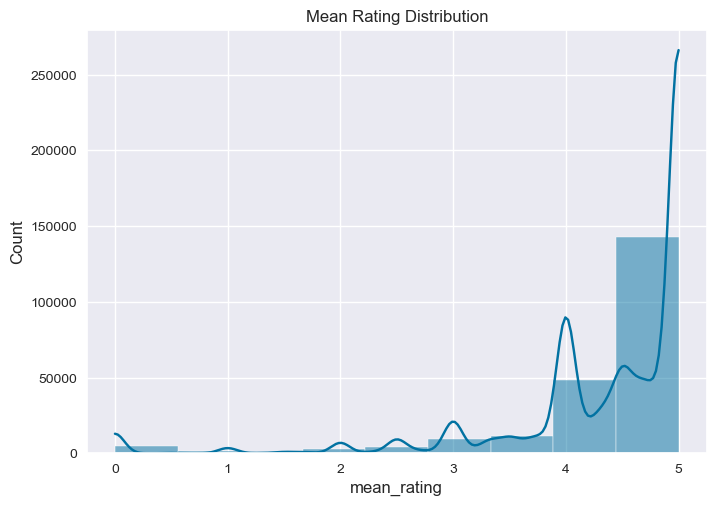

In [31]:
# make an sns_histplot of the ratings
sns.histplot(data=food_encoded, x='mean_rating', bins=9, kde=True)
plt.title('Mean Rating Distribution')
plt.show()


In [32]:
food_encoded_pca = food_encoded.drop(columns=['submitted', 'contributor_id', 'recipe_id', 'tags'])
food_encoded_pca = food_encoded_pca.dropna()

scaler = StandardScaler()
food_encoded_scaled = scaler.fit_transform(food_encoded_pca)
food_encoded_scaled = pd.DataFrame(normalize(food_encoded_scaled))

pca = PCA()
food_encoded_pca = pca.fit_transform(food_encoded_pca)

food_encoded_pca = pd.DataFrame(food_encoded_pca)

C:\Users\Victoria\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Victoria\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Victoria\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Victoria\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Victoria\anaconda3\lib\site-package

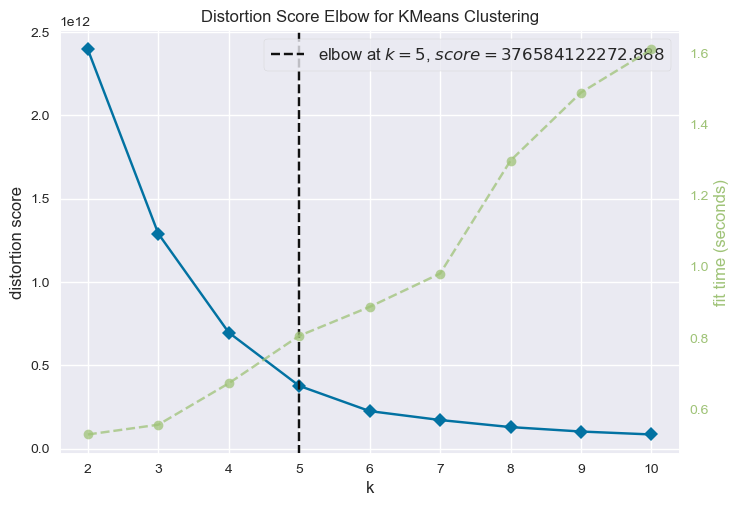

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [33]:
elbow = KElbowVisualizer(KMeans(), k=10)
elbow.fit(food_encoded_pca)
elbow.show()

In [34]:
pca = PCA(n_components=5)
food_encoded_pca = pca.fit_transform(food_encoded_scaled)

food_encoded_pca = pd.DataFrame(food_encoded_pca)

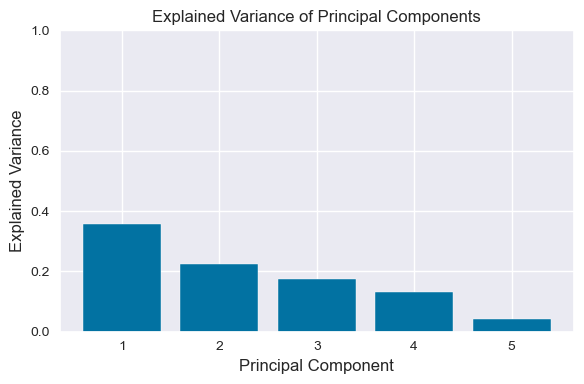

In [35]:
# make a histogram of explained variance of food_encoded_pca
plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.gcf().set_size_inches(6, 4)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.ylim(0, 1)
plt.title('Explained Variance of Principal Components')
plt.tight_layout()
plt.show()


In [36]:
pca.explained_variance_ratio_.sum()


0.9313912916133935

In [37]:
# rename the columns to PC1, PC2, etc.
food_encoded_pca.columns = ['PC' + str(i+1) for i in range(food_encoded_pca.shape[1])]
food_encoded_pca['mean_rating'] = food['mean_rating']
food_encoded_pca['reviews'] = food['reviews']
food_encoded_pca.head()


,PC1,PC2,PC3,PC4,PC5,mean_rating,reviews
0,-0.223346,-0.470291,0.396476,-0.541792,0.003441,5.0,3.0
1,-0.381486,0.797917,0.258711,0.119713,-0.293103,3.5,4.0
2,0.422678,0.233954,-0.858287,-0.037945,-0.088787,4.0,1.0
3,0.622643,-0.248490,-0.173025,-0.487018,-0.219322,4.5,2.0
4,-0.225169,-0.012786,-0.090150,0.905937,-0.288208,5.0,1.0


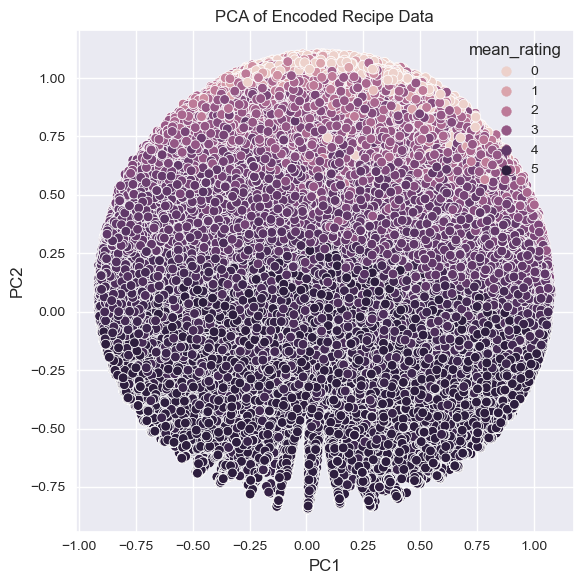

In [38]:
# plot the first two principal components
sns.scatterplot(data=food_encoded_pca, x='PC1', y='PC2', hue='mean_rating')
plt.title('PCA of Encoded Recipe Data')
plt.gcf().set_size_inches(6, 6)
plt.tight_layout()
plt.show()

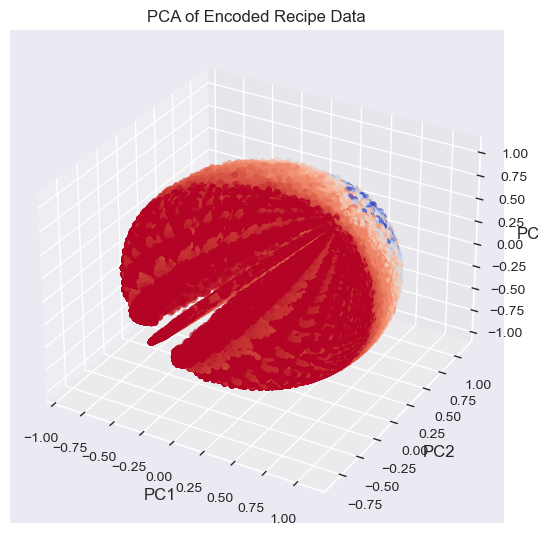

In [39]:
# plot the first three principle components of food_encoded_pca in 3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(food_encoded_pca['PC1'], food_encoded_pca['PC2'], food_encoded_pca['PC3'], c=food_encoded_pca['mean_rating'], cmap='coolwarm')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('PCA of Encoded Recipe Data')
plt.tight_layout()
plt.show()


In [40]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(food_encoded_pca.drop(columns=['mean_rating', 'reviews']))
food_encoded_pca['cluster'] = kmeans.labels_


C:\Users\Victoria\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


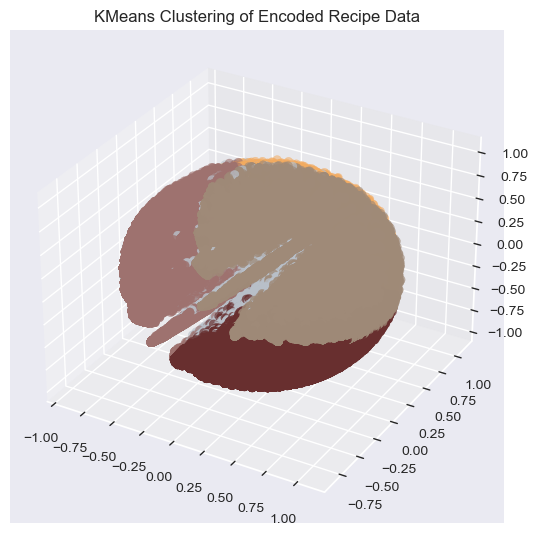

In [41]:
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
pal = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
# plot 3d projection of data in reduced dimension
x = food_encoded_pca['PC1']
y = food_encoded_pca['PC2']
z = food_encoded_pca['PC3']
fig = plt.figure()
ax = plt.subplot(111, projection='3d')
ax.scatter(x, y, z, s=40, c=food_encoded_pca['cluster'], marker='o', cmap=cmap)
plt.title('KMeans Clustering of Encoded Recipe Data')
plt.tight_layout()
plt.show()



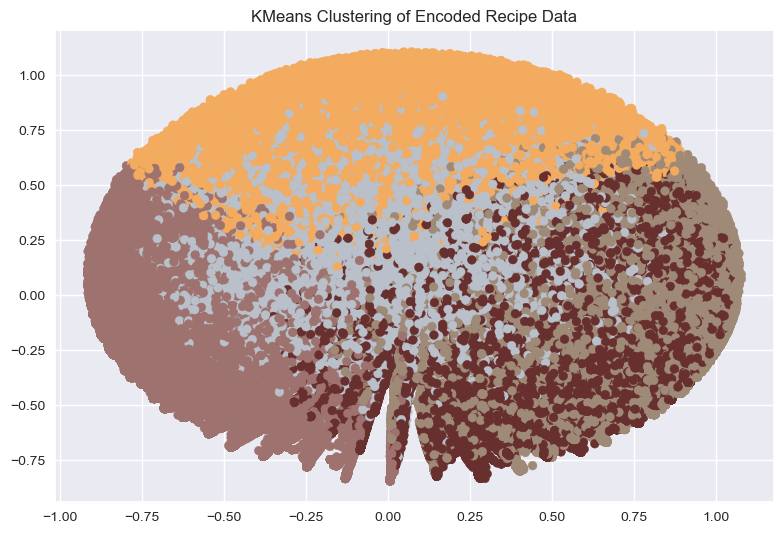

In [42]:
ax = plt.subplot()
ax.scatter(x, y, s=40, c=food_encoded_pca['cluster'], marker='o', cmap=cmap)
plt.title('KMeans Clustering of Encoded Recipe Data')
plt.tight_layout()
plt.show()

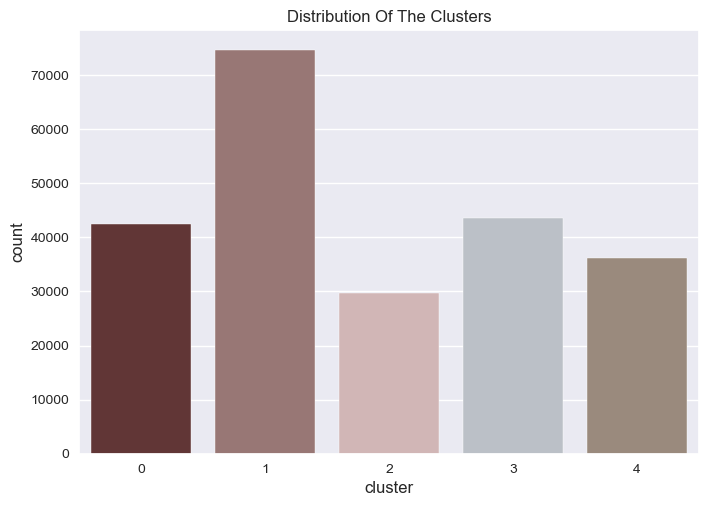

In [43]:
pl = sns.countplot(x=food_encoded_pca['cluster'],  palette = pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

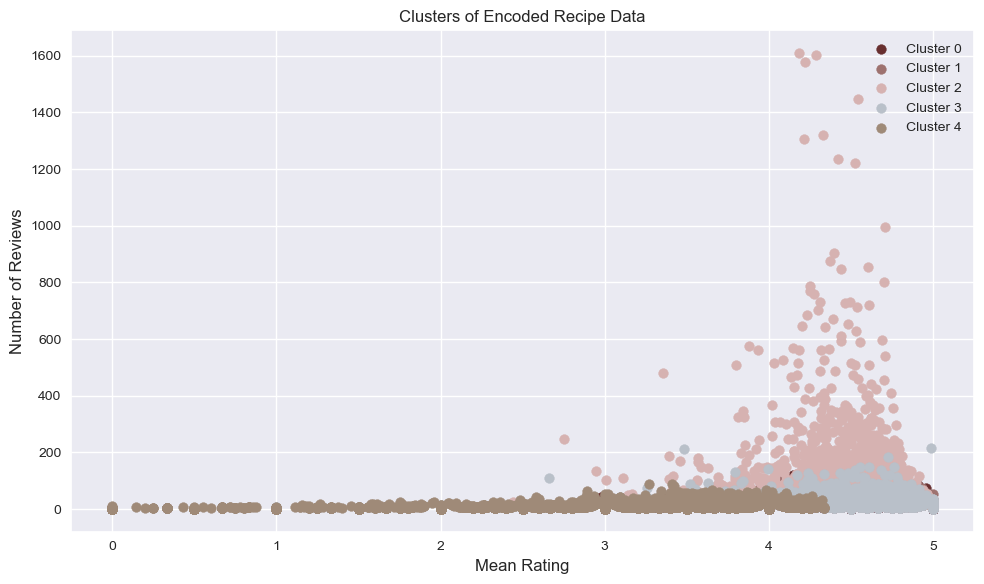

In [44]:
# visualizing the clusters
df1 = food_encoded_pca[food_encoded_pca['cluster'] == 0]
df2 = food_encoded_pca[food_encoded_pca['cluster'] == 1]
df3 = food_encoded_pca[food_encoded_pca['cluster'] == 2]
df4 = food_encoded_pca[food_encoded_pca['cluster'] == 3]
df5 = food_encoded_pca[food_encoded_pca['cluster'] == 4]

plt.figure(figsize=(10, 6))
plt.scatter(df1['mean_rating'], df1['reviews'], c=pal[0], label='Cluster 0')
plt.scatter(df2['mean_rating'], df2['reviews'], c=pal[1], label='Cluster 1')
plt.scatter(df3['mean_rating'], df3['reviews'], c=pal[2], label='Cluster 2')
plt.scatter(df4['mean_rating'], df4['reviews'], c=pal[3], label='Cluster 3')
plt.scatter(df5['mean_rating'], df5['reviews'], c=pal[4], label='Cluster 4')
plt.xlabel('Mean Rating')
plt.ylabel('Number of Reviews')
plt.title('Clusters of Encoded Recipe Data')
plt.legend()
plt.tight_layout()
plt.show()


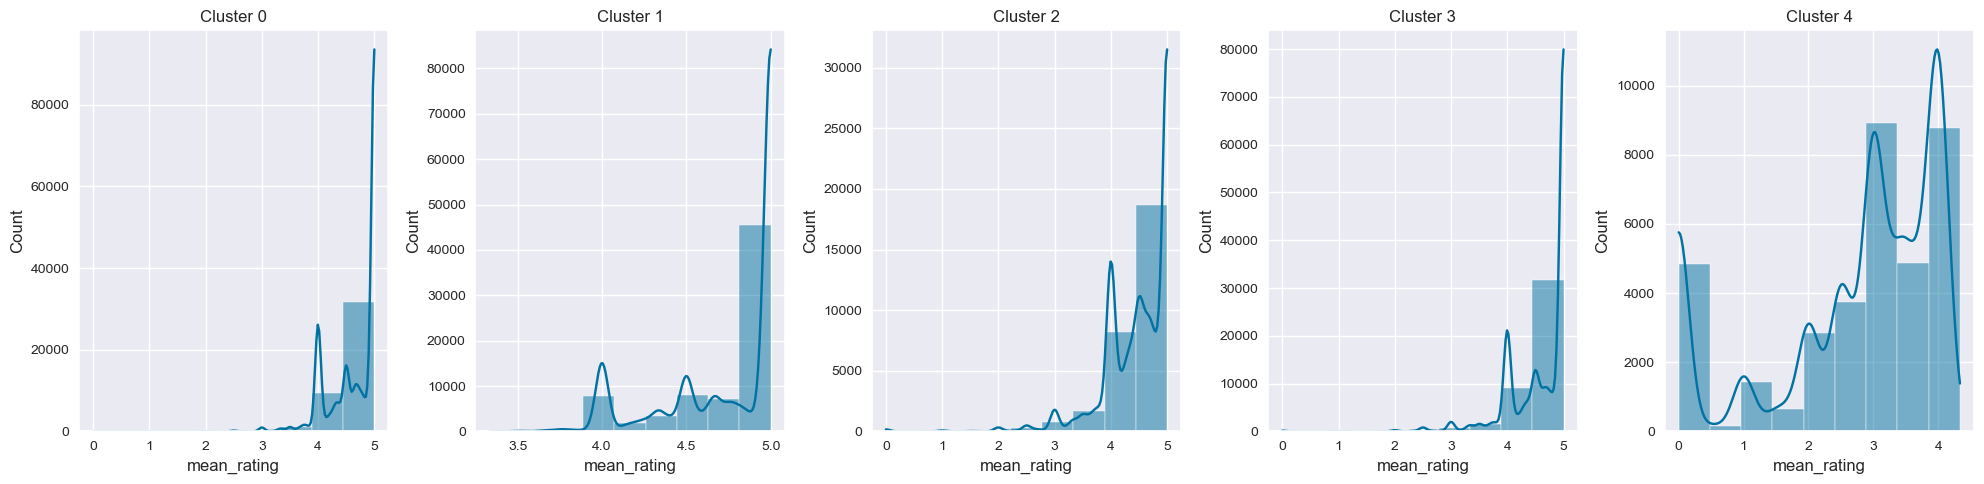

In [45]:

fig, ax = plt.subplots(1, 5, figsize=(20, 5))
sns.histplot(data=df1, x='mean_rating', bins=9, kde=True, ax=ax[0])
sns.histplot(data=df2, x='mean_rating', bins=9, kde=True, ax=ax[1])
sns.histplot(data=df3, x='mean_rating', bins=9, kde=True, ax=ax[2])
sns.histplot(data=df4, x='mean_rating', bins=9, kde=True, ax=ax[3])
sns.histplot(data=df5, x='mean_rating', bins=9, kde=True, ax=ax[4])
ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')
ax[3].set_title('Cluster 3')
ax[4].set_title('Cluster 4')
plt.tight_layout()
plt.show()


# KNN

In [46]:
food_encoded.columns

Index(['recipe_id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'n_steps', 'n_ingredients', 'calories', 'total_fat', 'sugar', 'sodium',
       'protein', 'sat_fat', 'carbs', 'reviews', 'mean_rating'],
      dtype='object')

In [47]:
food_encoded['tags']

0         60-minutes-or-less time-to-make course main-in...
1         30-minutes-or-less time-to-make course main-in...
2         time-to-make course preparation main-dish chil...
3         60-minutes-or-less time-to-make course main-in...
4         weeknight time-to-make course main-ingredient ...
                                ...                        
226652    ham 60-minutes-or-less time-to-make course mai...
226653    15-minutes-or-less time-to-make course prepara...
226654    60-minutes-or-less time-to-make course main-in...
226655    30-minutes-or-less time-to-make course prepara...
226656    30-minutes-or-less time-to-make course prepara...
Name: tags, Length: 226657, dtype: object

In [48]:
numerical_features = food_encoded[['minutes', 'n_steps', 'n_ingredients', 'calories', 
                                   'total_fat', 'sugar', 'sodium', 'protein', 'sat_fat', 'carbs']]

scaler = StandardScaler()
numerical_features_scaled = scaler.fit_transform(numerical_features)

numerical_features_scaled

array([[-0.00211663,  0.20435193, -0.5491062 , ..., -0.59392769,
        -0.46823466, -0.15762816],
       [-0.00212217, -0.12899193, -0.81641913, ...,  0.62116881,
        -0.29436485,  0.05644168],
       [-0.0021    , -0.62900771,  1.0547714 , ..., -0.15207442,
        -0.18736804, -0.09466644],
       ...,
       [-0.00211995, -0.46233578, -0.28179326, ..., -0.19625974,
        -0.16061884, -0.04429707],
       [-0.00212239, -0.12899193,  0.2528326 , ..., -0.19625974,
        -0.16061884, -0.04429707],
       [-0.00212438, -0.79567964, -0.5491062 , ..., -0.19625974,
        -0.16061884, -0.04429707]])

In [49]:
# transform tags columns into a binary encoded matrix
vectorizer = CountVectorizer(binary=True)
tags_encoded = vectorizer.fit_transform(food_encoded['tags']).toarray()

In [50]:
combined_features = np.hstack([numerical_features_scaled, tags_encoded])

In [51]:
combined_features

array([[-0.00211663,  0.20435193, -0.5491062 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00212217, -0.12899193, -0.81641913, ...,  0.        ,
         0.        ,  0.        ],
       [-0.0021    , -0.62900771,  1.0547714 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.00211995, -0.46233578, -0.28179326, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00212239, -0.12899193,  0.2528326 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00212438, -0.79567964, -0.5491062 , ...,  0.        ,
         0.        ,  0.        ]])

In [52]:
#get 100 nearest neighbors
knn = NearestNeighbors(n_neighbors=100, metric='cosine') 
knn.fit(combined_features)

NearestNeighbors(metric='cosine', n_neighbors=100)

In [53]:
def recommendation_list_knn(userId):
    list_of_user_recipeIds = interactions[interactions['user_id'] == userId]['recipe_id'].tolist()
    result_list = []
    recommendations = {}
    
    for id in list_of_user_recipeIds:
        if not food_encoded[food_encoded['recipe_id'] == id].empty:
            target_index = food_encoded[food_encoded['recipe_id'] == id].index[0]
            distances, indices = knn.kneighbors(combined_features[target_index].reshape(1, -1))
            recommended_indices = [i for i in indices[0] if i != target_index]
            recommended_recipe_ids = food_encoded.iloc[recommended_indices]['recipe_id'].tolist()
            result_list.extend(recommended_recipe_ids)
            
    # remove duplicates
    unique_results = set(result_list)
    result_list = [item for item in unique_results if item not in list_of_user_recipeIds]
    
    print('{1} recommendations based on KNearestNeighbors.'.format(userId, len(result_list)))
    return result_list
    
a = recommendation_list_knn(3288)
len(a)

8464 recommendations based on KNearestNeighbors.


8464

# Apriori

In [54]:
grouped = merged_df.groupby('user_id')['recipe_id'].agg(lambda x: list(x) if len(x) > 1 else None)

In [55]:
grouped = grouped.dropna()
grouped_df = grouped.reset_index()

In [56]:
expanded_recipes_df = grouped_df.recipe_id.apply(pd.Series)
expanded_recipes_df = expanded_recipes_df.fillna(0)
expanded_recipes_df.columns = [f'Recipe{i+1}' for i in expanded_recipes_df.columns]
expanded_recipes_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 694 entries, 0 to 693
Columns: 7432 entries, Recipe1 to Recipe7432
dtypes: float64(7432)
memory usage: 39.4 MB


In [57]:
expanded_recipes_df = expanded_recipes_df.astype(int)

In [58]:
# Initialize an empty list to hold all transactions
transactions = []

# Iterate over each row in the DataFrame
for index, row in expanded_recipes_df.iterrows():
    transaction = [recipe_id for recipe_id in row[1:] if recipe_id != 0.0]
    transactions.append(transaction)

In [59]:
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
transaction_df = pd.DataFrame(te_ary, columns=te.columns_)
transaction_df.head()

,40,41,45,46,49,58,62,66,85,91,...,536679,536726,536729,536734,536990,537073,537175,537241,537458,537459
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [60]:
frequent_itemsets = fpgrowth(transaction_df, min_support=0.01, use_colnames=True)

In [61]:
frequent_itemsets

,support,itemsets
0,0.122478,(39087)
1,0.103746,(29679)
2,0.097983,(78814)
3,0.086455,(101104)
4,0.079251,(5170)
...,...,...
24035,0.010086,"(398464, 73033)"
24036,0.010086,"(334452, 155021)"
24037,0.010086,"(281313, 102909)"
24038,0.011527,"(444761, 128566)"


In [62]:
# frequent_itemsets2 = fpgrowth(transaction_df, min_support=0.001, use_colnames=True)

In [63]:
rules = association_rules(frequent_itemsets, metric = "lift", min_threshold = 1)
rules.sort_values('confidence', ascending = False, inplace = True)

In [64]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
37040,"(90674, 108364)",(28148),0.010086,0.141210,0.010086,1.000000,7.081633,0.008662,inf,0.867540
43452,"(106251, 148215)",(155018),0.010086,0.072046,0.010086,1.000000,13.880000,0.009360,inf,0.937409
1870,"(98724, 25885)",(56103),0.011527,0.122478,0.011527,1.000000,8.164706,0.010116,inf,0.887755
36064,"(27208, 69173, 108775)",(39087),0.010086,0.122478,0.010086,1.000000,8.164706,0.008851,inf,0.886463
17498,"(26257, 32844, 22782)",(34382),0.010086,0.095101,0.010086,1.000000,10.515152,0.009127,inf,0.914119
...,...,...,...,...,...,...,...,...,...,...
38999,(69173),"(158832, 90674)",0.164265,0.012968,0.010086,0.061404,4.734893,0.007956,1.051604,0.943842
24050,(69173),"(27144, 34382)",0.164265,0.014409,0.010086,0.061404,4.261404,0.007720,1.050069,0.915764
31605,(69173),(66976),0.164265,0.021614,0.010086,0.061404,2.840936,0.006536,1.042393,0.775369
11793,(69173),(28091),0.164265,0.037464,0.010086,0.061404,1.639001,0.003932,1.025506,0.466502


In [65]:
# Check
product = frozenset({69173})
filtered = rules[rules['antecedents'] == product].head(10)

print(f'Shape: {filtered.shape}'  )
filtered = filtered.sort_values(by=['confidence', 'lift'], ascending=[False, False])
filtered

Shape: (10, 10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
11984,(69173),(82102),0.164265,0.106628,0.044669,0.271930,2.550261,0.027153,1.227041,0.727364
22959,(69173),(66596),0.164265,0.106628,0.041787,0.254386,2.385728,0.024271,1.198169,0.695006
16,(69173),(39087),0.164265,0.122478,0.041787,0.254386,2.076987,0.021668,1.176911,0.620452
10505,(69173),(27208),0.164265,0.157061,0.041787,0.254386,1.619668,0.015987,1.130531,0.457788
19091,(69173),(67256),0.164265,0.115274,0.040346,0.245614,2.130702,0.021410,1.172777,0.634975
4345,(69173),(28148),0.164265,0.141210,0.038905,0.236842,1.677229,0.015709,1.125311,0.483142
22256,(69173),(22782),0.164265,0.125360,0.037464,0.228070,1.819318,0.016872,1.133056,0.538859
4356,(69173),(77397),0.164265,0.138329,0.037464,0.228070,1.648757,0.014741,1.116256,0.470822
440,(69173),(78814),0.164265,0.097983,0.036023,0.219298,2.238132,0.019928,1.155393,0.661931
30195,(69173),(32204),0.164265,0.118156,0.034582,0.210526,1.781772,0.015173,1.117003,0.525000


In [66]:
def recommendation_list_apriori(userId):
    list_of_user_recipeIds = interactions[interactions['user_id'] == userId]['recipe_id'].tolist()
    result_list = []
    
    for recipeId in list_of_user_recipeIds:
        recipeIds_list = []
        product = frozenset({recipeId})
        filtered = rules[rules['antecedents'] == product]
        if not filtered.empty:
            recipeIds_list = [list(fset)[0] for fset in filtered['consequents'].tolist()]
            result_list.extend(recipeIds_list)
    
    # remove duplicates
    unique_results = set(result_list)
    result_list = [item for item in unique_results if item not in list_of_user_recipeIds]
    
    print('{1} recommendations based on Apriori.'.format(userId, len(result_list)))
    return result_list

# Check 
b = recommendation_list_apriori(3288)
len(b)

413 recommendations based on Apriori.


413

# Matrix Factorization

In [67]:
rating_matrix_df = interactions.pivot(index='user_id', columns='recipe_id', values='rating')
rating_matrix_df = rating_matrix_df.fillna(0)

rating_matrix_df.head(3)

recipe_id,40,41,45,46,49,52,58,62,63,66,...,536679,536726,536729,536734,536990,537073,537175,537241,537458,537459
user_id,,,,,,,,,,,,,,,,,,,,,
1535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
rating_matrix_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 694 entries, 1535 to 2000498330
Columns: 129015 entries, 40 to 537459
dtypes: float64(129015)
memory usage: 683.1 MB


In [69]:
rating_matrix = rating_matrix_df.values
user_ratings_mean = np.mean(rating_matrix, axis = 1)
rating_matrix_demeaned = rating_matrix - user_ratings_mean.reshape(-1, 1)

k = 50
U, sigma, Vt = svds(rating_matrix_demeaned, k=k)

sigma = np.diag(sigma)

predicted_ratings = np.dot(np.dot(U, sigma), Vt)
predicted_ratings_df = pd.DataFrame(predicted_ratings, index=rating_matrix_df.index, columns = rating_matrix_df.columns)

predicted_ratings_df.head()

recipe_id,40,41,45,46,49,52,58,62,63,66,...,536679,536726,536729,536734,536990,537073,537175,537241,537458,537459
user_id,,,,,,,,,,,,,,,,,,,,,
1535,-0.002108,-0.004695,-0.005223,0.005688,-0.029921,0.005558,-0.013917,-0.006039,-0.007461,0.007993,...,-0.009944,-0.009944,-0.007741,-0.012067,-0.004285,-0.007224,-0.006439,-0.011961,-0.008333,-0.008333
2310,-0.001686,-0.001850,-0.001917,-0.000077,0.013716,0.024262,0.001408,-0.001398,-0.002218,0.012952,...,-0.007458,-0.007458,-0.017483,-0.003654,-0.012293,-0.002653,-0.023191,-0.005943,-0.009784,-0.009784
3288,-0.002225,-0.002192,-0.002200,0.000016,-0.013357,0.003948,-0.002180,-0.001539,-0.002842,0.001394,...,-0.001400,-0.001400,0.010913,-0.003251,0.008825,-0.003010,-0.001767,0.001432,-0.002925,-0.002925
4291,-0.002442,-0.002580,-0.002557,0.000069,-0.002123,-0.003417,0.003794,-0.001336,-0.003578,-0.009426,...,-0.003609,-0.003609,0.018019,-0.004504,0.017437,-0.003820,-0.010994,0.002012,-0.011410,-0.011410
4439,-0.000299,0.001653,0.001280,0.006549,0.008368,-0.010722,-0.014550,0.002756,-0.000553,-0.036647,...,-0.012956,-0.012956,-0.003210,-0.002290,0.008848,-0.000659,-0.033106,-0.027287,-0.022318,-0.022318


In [70]:
predicted_ratings_df.describe()

recipe_id,40,41,45,46,49,52,58,62,63,66,...,536679,536726,536729,536734,536990,537073,537175,537241,537458,537459
count,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000,...,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000,694.000000
mean,-0.013313,-0.012612,-0.012184,-0.008783,-0.001569,-0.004326,-0.001046,-0.006946,-0.013357,0.016964,...,-0.005833,-0.005833,0.009764,-0.012798,0.000247,-0.013107,-0.003981,-0.003818,-0.006990,-0.006990
std,0.024730,0.023481,0.022953,0.025448,0.187199,0.187650,0.189585,0.023798,0.023037,0.323449,...,0.186074,0.186074,0.262972,0.021802,0.184265,0.022495,0.186979,0.186801,0.187094,0.187094
min,-0.299882,-0.291126,-0.286447,-0.297653,-0.283444,-0.285094,-0.288764,-0.266081,-0.292475,-0.304649,...,-0.285811,-0.285811,-0.311002,-0.290484,-0.295387,-0.286215,-0.291275,-0.294486,-0.285035,-0.285035
25%,-0.012846,-0.011173,-0.010570,-0.006691,-0.016965,-0.014823,-0.015404,-0.004463,-0.012943,-0.015459,...,-0.014434,-0.014434,-0.014450,-0.013235,-0.013429,-0.012822,-0.017785,-0.017026,-0.018335,-0.018335
50%,-0.006550,-0.006118,-0.005800,-0.001205,-0.002037,-0.006270,-0.005696,-0.001992,-0.006965,-0.003895,...,-0.006985,-0.006985,-0.004365,-0.007181,-0.004641,-0.007055,-0.007544,-0.007241,-0.009030,-0.009030
75%,-0.002894,-0.002951,-0.002726,0.000765,0.010794,0.001680,0.004867,-0.000397,-0.003554,0.008040,...,-0.001951,-0.001951,0.007572,-0.003643,0.005618,-0.003573,0.001972,0.000976,-0.002052,-0.002052
max,0.094648,0.007810,0.007942,0.068349,4.821528,4.878562,4.865129,0.140453,0.007380,4.902293,...,4.845173,4.845173,4.858430,0.036773,4.672746,0.007003,4.802216,4.809561,4.866031,4.866031


In [71]:
def recommendation_list_mf(userId):
    """
    """
    sorted_user_predictions = predicted_ratings_df.loc[userId].sort_values(ascending=False)    
    user_full = merged_df[merged_df['user_id'] == userId].sort_values(['rating'], ascending=False)
    
    recommendations = (recipes[~recipes['id'].isin(user_full['id'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'id',
               right_on = 'recipe_id').
         rename(columns = {userId: 'Predictions'}).
         sort_values('Predictions', ascending = False))
    
    # drop rows that do not have Predictions and negative Predictions
    recommendations = recommendations[recommendations['Predictions'] > 0].dropna()
    
    result_list = recommendations['id'].tolist()
    print('{1} recommendations based on Matrix Factorization.'.format(userId, len(result_list)))
    return result_list
    
# Check 
c  = recommendation_list_mf(3288)
len(c)

37859 recommendations based on Matrix Factorization.


37859

# Recommendation Integration
combine all algos together.

In [72]:
new_recipes.head(3)

,name,id,minutes,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,n_ratings,avg_rating
0,arriba baked winter squash mexican style,137739,55,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,3,5.0
1,a bit different breakfast pizza,31490,30,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,4,3.5
2,all in the kitchen chili,112140,130,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13,1,4.0


In [73]:
interactions['user_id']

3          126440
4           57222
13         255338
21         353579
32           5060
            ...  
1132348    496803
1132349    169430
1132353    126435
1132355    140132
1132356    199020
Name: user_id, Length: 315087, dtype: int64

In [76]:
def recommendation(userId, max_num_recommendation):
    """
    """
    list_of_user_recipeIds = raw_int[raw_int['user_id'] == userId]['recipe_id'].tolist()
    print('User with Id {0} has already rated {1} recipes.'.format(userId, len(list_of_user_recipeIds)))
    print('------------------------------')
    
    mf_list = recommendation_list_mf(userId)
    ap_list = recommendation_list_apriori(userId)
    knn_list = recommendation_list_knn(userId)
    
    set_mf_list = set(mf_list)
    set_ap_list = set(ap_list)
    set_knn_list = set(knn_list)
    
    recommendations_set = set_mf_list.intersection(set_ap_list).intersection(set_knn_list)
    recommendations_list = list(recommendations_set)
    
    filtered_df = new_recipes[new_recipes['id'].isin(recommendations_list)]
    sorted_df = filtered_df.sort_values(by=['avg_rating', 'n_ratings'], ascending=[False, False]).head(max_num_recommendation)
    
    formatted_strings = []
    count = 1
    for index, row in sorted_df.iterrows():
        name = row['name']
        strs = name.split(" ")
        filtered_str = [item for item in strs if item != '']
        formatted_name = " ".join(filtered_str)

        string = f"{count}. {formatted_name} - total {row['n_ratings']} ratings - avergae: {row['avg_rating']}."
        formatted_strings.append(string)
        count+=1
    
    result_string = "\n".join(formatted_strings)
    print('------------------------------')
    print('Top {0} recommendations: '.format(max_num_recommendation))
    print(result_string)
    
    return sorted_df

# Check
b = recommendation(3288, 5) # user with Id 3288 with max 5 recommendations
b

User with Id 3288 has already rated 201 recipes.
------------------------------
37859 recommendations based on Matrix Factorization.
413 recommendations based on Apriori.
8464 recommendations based on KNearestNeighbors.
------------------------------
Top 5 recommendations: 
1. tsr version of t g i friday s black bean soup by todd wilbur - total 244 ratings - avergae: 4.8.
2. cinnamon swirl quick bread - total 175 ratings - avergae: 4.8.
3. best baked potato - total 136 ratings - avergae: 4.8.
4. cranberry feta and walnut salad - total 96 ratings - avergae: 4.8.
5. kittencal s easy and delicious ranch parmesan chicken - total 424 ratings - avergae: 4.7.


,name,id,minutes,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,n_ratings,avg_rating
212469,tsr version of t g i friday s black bean soup...,102274,75,"['time-to-make', 'course', 'main-ingredient', ...","[392.5, 12.0, 17.0, 19.0, 45.0, 7.0, 19.0]",9,['heat 2 tablespoons of oil in a large saucepa...,from www.topsecretrecipes.com i got this copyc...,"['vegetable oil', 'white onion', 'celery', 'ca...",16,244,4.8
52792,cinnamon swirl quick bread,92016,60,"['60-minutes-or-less', 'time-to-make', 'course...","[2539.8, 85.0, 1115.0, 120.0, 82.0, 162.0, 158.0]",11,"['preheat oven to 350f', 'in a large mixing bo...",this rich quick bread is a favorite with my fa...,"['butter', 'sugar', 'egg', 'all-purpose flour'...",9,175,4.8
21619,best baked potato,71933,70,"['weeknight', 'time-to-make', 'course', 'main-...","[284.1, 0.0, 11.0, 0.0, 14.0, 0.0, 21.0]",10,['heat oven to 350f and position racks in top ...,another keeper from alton brown's show good ea...,"['russet potato', 'canola oil', 'kosher salt']",3,136,4.8
59547,cranberry feta and walnut salad,59829,5,"['15-minutes-or-less', 'time-to-make', 'course...","[411.1, 46.0, 106.0, 14.0, 13.0, 36.0, 11.0]",6,"['toss greens , cranberries , cheese and walnu...",a tasty and beautiful salad. you may choose to...,"['mixed salad greens', 'dried sweetened cranbe...",9,96,4.8
115357,kittencal s easy and delicious ranch parmesan ...,200296,40,"['60-minutes-or-less', 'time-to-make', 'course...","[486.3, 51.0, 8.0, 34.0, 59.0, 48.0, 5.0]",8,"['set oven to 400 degrees', 'in a shallow bowl...","there are plenty versions of this recipe, this...","['boneless skinless chicken breasts', 'dry bre...",8,424,4.7
